## Indicator Strategy Exploration — y_logret_24h_huber

Purpose: load model predictions and artifacts from the BINANCE_BTCUSDT.P, 60 run to support indicator-based strategy evaluation (similar to `strategies/inspect_y_logret_performance.ipynb`).

Data sources in `.../diagnosis/y_logret_24h_huber`:
- **pred_train.csv / pred_val.csv / pred_test.csv**: `timestamp`, `y_true` (target `y_logret_24h`), `y_pred` (model prediction)
- **metrics.json**: RMSE per split
- **best_params.json**: tuned LightGBM parameters
- **pipeline_config.json**: input paths, target specification, splits, tuning config
- **feature_importance.csv**: feature importance (gain, split)
- **tuning_trials.csv / model.txt / run_metadata.json / prep_metadata.json / paths.json**: supplementary artifacts

We'll load and lightly inspect these to prepare for indicator strategy experiments.


In [2]:
from __future__ import annotations
import json
from pathlib import Path

import pandas as pd

# Paths
DIAG_DIR = Path("/Volumes/Extreme SSD/trading_data/cex/models/BINANCE_BTCUSDT.P, 60/diagnosis/y_4u2d_24h_hmm")

PRED_TRAIN = DIAG_DIR / "pred_train.csv"
PRED_VAL = DIAG_DIR / "pred_val.csv"
PRED_TEST = DIAG_DIR / "pred_test.csv"

METRICS_JSON = DIAG_DIR / "metrics.json"
BEST_PARAMS_JSON = DIAG_DIR / "best_params.json"
PIPELINE_CONFIG_JSON = DIAG_DIR / "pipeline_config.json"
FEATURE_IMPORTANCE_CSV = DIAG_DIR / "feature_importance.csv"

PD_READ_CSV_KW = dict(parse_dates=["timestamp"], infer_datetime_format=True)

DIAG_DIR, PRED_TRAIN.exists(), PRED_VAL.exists(), PRED_TEST.exists()


(PosixPath('/Volumes/Extreme SSD/trading_data/cex/models/BINANCE_BTCUSDT.P, 60/diagnosis/y_4u2d_24h_hmm'),
 True,
 True,
 True)

In [3]:
# Load metrics and key configs
with METRICS_JSON.open() as f:
    metrics = json.load(f)
with BEST_PARAMS_JSON.open() as f:
    best_params = json.load(f)
with PIPELINE_CONFIG_JSON.open() as f:
    pipeline_config = json.load(f)

metrics, list(best_params.items())[:5], pipeline_config["target"], pipeline_config["split"]


({'auc_train': 0.95647486186793,
  'auc_val': 0.5959153074108432,
  'auc_test': 0.6978229922794777},
 [('learning_rate', 0.1),
  ('num_leaves', 20),
  ('max_depth', -1),
  ('min_data_in_leaf', 25),
  ('feature_fraction', 0.75)],
 {'variable': 'y_tp_before_sl_u0.04_d0.02_24h',
  'objective': {'name': 'binary', 'params': {}}},
 {'train_ratio': 0.7, 'val_ratio': 0.15, 'test_ratio': 0.15})

In [4]:
# Load prediction CSVs
pred_train = pd.read_csv(PRED_TRAIN, **PD_READ_CSV_KW)
pred_val = pd.read_csv(PRED_VAL, **PD_READ_CSV_KW)
pred_test = pd.read_csv(PRED_TEST, **PD_READ_CSV_KW)

for name, df in ("train", pred_train), ("val", pred_val), ("test", pred_test):
    print(name, df.shape, df.columns.tolist(), df.timestamp.min(), df.timestamp.max())

# Quick sanity checks
assert set(pred_train.columns) == {"timestamp", "y_true", "y_pred"}
assert set(pred_val.columns) == {"timestamp", "y_true", "y_pred"}
assert set(pred_test.columns) == {"timestamp", "y_true", "y_pred"}

# Concatenate with split label for unified analysis later
pred_train["split"] = "train"
pred_val["split"] = "val"
pred_test["split"] = "test"

pred_test_original = pred_test.copy()
pred_test = pred_test[pred_test['timestamp'] <= pd.to_datetime('2025-07-23 20:00:00')]

for df in (pred_train, pred_val, pred_test):
    #df["ind_pred_pos"] = np.sign(pd.to_numeric(df["y_pred"], errors="coerce")).astype(int) # long and short
    df["ind_pred_pos"] = (df["y_pred"] > 0.155).astype(int) # long only
pred_all = pd.concat([pred_train, pred_val, pred_test], ignore_index=True)
pred_all.sort_values("timestamp", inplace=True)
pred_all.head(3), pred_all.tail(3)


train (15201, 3) ['timestamp', 'y_true', 'y_pred'] 2023-01-31 00:00:00 2024-10-25 08:00:00
val (3257, 3) ['timestamp', 'y_true', 'y_pred'] 2024-10-25 09:00:00 2025-03-10 01:00:00
test (3259, 3) ['timestamp', 'y_true', 'y_pred'] 2025-03-10 02:00:00 2025-07-23 20:00:00


/var/folders/my/18kmg51d1lz3l9rnds2gkf1r0000gn/T/ipykernel_4194/2027478312.py:2: FutureWarning: The argument 'infer_datetime_format' is deprecated and will be removed in a future version. A strict version of it is now the default, see https://pandas.pydata.org/pdeps/0004-consistent-to-datetime-parsing.html. You can safely remove this argument.
  pred_train = pd.read_csv(PRED_TRAIN, **PD_READ_CSV_KW)
/var/folders/my/18kmg51d1lz3l9rnds2gkf1r0000gn/T/ipykernel_4194/2027478312.py:3: FutureWarning: The argument 'infer_datetime_format' is deprecated and will be removed in a future version. A strict version of it is now the default, see https://pandas.pydata.org/pdeps/0004-consistent-to-datetime-parsing.html. You can safely remove this argument.
  pred_val = pd.read_csv(PRED_VAL, **PD_READ_CSV_KW)
/var/folders/my/18kmg51d1lz3l9rnds2gkf1r0000gn/T/ipykernel_4194/2027478312.py:4: FutureWarning: The argument 'infer_datetime_format' is deprecated and will be removed in a future version. A strict v

(            timestamp  y_true    y_pred  split  ind_pred_pos
 0 2023-01-31 00:00:00     0.0  0.122124  train             0
 1 2023-01-31 01:00:00     0.0  0.122124  train             0
 2 2023-01-31 02:00:00     0.0  0.122124  train             0,
                 timestamp  y_true    y_pred split  ind_pred_pos
 21714 2025-07-23 18:00:00     0.0  0.077309  test             0
 21715 2025-07-23 19:00:00     0.0  0.077309  test             0
 21716 2025-07-23 20:00:00     0.0  0.077309  test             0)

In [5]:
print("Overall class distribution for test:")
print(pred_test['y_true'].value_counts())

Overall class distribution for test:
y_true
0.0    2999
1.0     260
Name: count, dtype: int64


In [6]:
def _load_ohlcv(path: Path) -> pd.DataFrame:
    df = pd.read_csv(path)
    # Prefer 'timestamp' if present, else 'time'
    if 'timestamp' in df.columns:
        ts = pd.to_datetime(df['timestamp'], errors='coerce', utc=True)
    elif 'time' in df.columns:
        ts = pd.to_datetime(df['time'], errors='coerce', utc=True)
    else:
        raise ValueError("OHLCV CSV must have 'timestamp' or 'time' column")
    df['timestamp'] = ts.dt.tz_convert('UTC').dt.tz_localize(None)
    # Normalize column names
    colmap = {}
    for c in df.columns:
        lc = str(c).lower()
        if lc in {'open', 'high', 'low', 'close'}:
            colmap[c] = lc
    df = df.rename(columns=colmap)
    required = {'open', 'high', 'low', 'close', 'timestamp'}
    if not required.issubset(df.columns):
        missing = required - set(df.columns)
        raise ValueError(f"OHLCV CSV missing columns: {sorted(missing)}")
    return df[['timestamp', 'open', 'high', 'low', 'close']].dropna(subset=['timestamp'])

ohlcv = _load_ohlcv("/Users/noel/projects/trading_cex/data/BINANCE_BTCUSDT.P, 60.csv")

In [7]:
# Optional: load feature importances
try:
    fi = pd.read_csv(FEATURE_IMPORTANCE_CSV)
    fi.sort_values("importance_gain", ascending=False, inplace=True)
    print(fi.head(10))
except FileNotFoundError:
    print("feature_importance.csv not found")


                               feature  importance_gain  importance_split
0                      time_dow_sin_1H      1251.791931                 8
1                   close_var_5_50_12H       924.753593                 7
2              close_bb_width_20_2_12H       730.961815                 5
3                   close_cvar_5_50_4H       692.595993                 4
4                      close_wma_20_1D       526.436981                 2
5                     close_sma_20_12H       518.804993                 1
6           close_candle_body_ratio_1D       415.069794                 3
7     close_obv_over_dollar_vol_20_12H       370.756493                 3
8                      close_hv_20_12H       367.414612                 3
9  close_macd_line_12_26_over_atr14_4H       355.963013                 2


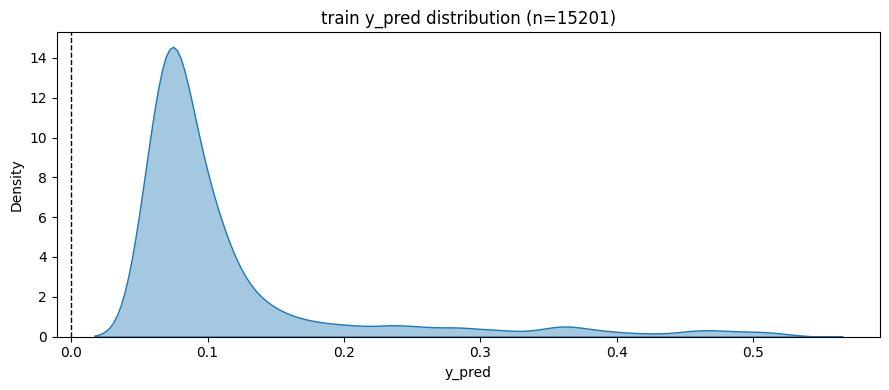

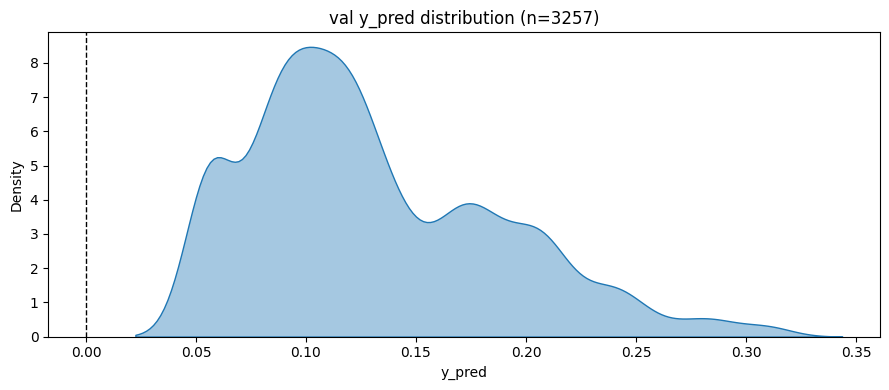

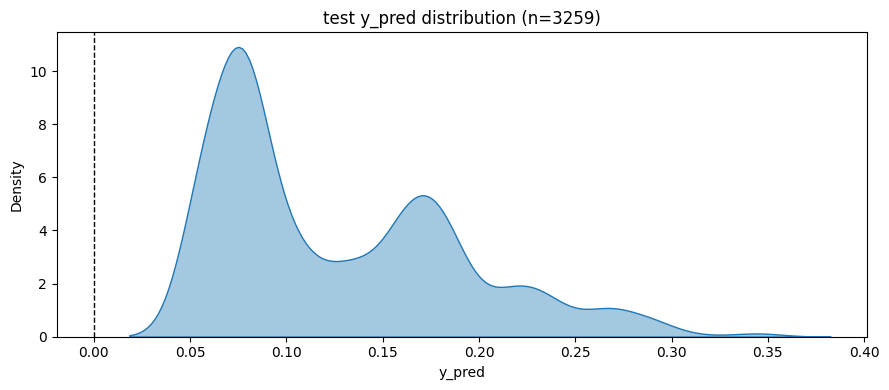

In [8]:
# Separate figures: one distribution plot per split (y_pred)
import matplotlib.pyplot as plt

try:
    import seaborn as sns  # type: ignore
except Exception:
    sns = None

splits = ["train", "val", "test"]

# Keep consistent x-limits across panels for comparability
q_low = float(pred_all["y_pred"].quantile(0.01))
q_high = float(pred_all["y_pred"].quantile(0.99))

for split_name in splits:
    df_split = pred_all[pred_all["split"] == split_name]
    fig, ax = plt.subplots(figsize=(9, 4))
    if sns is not None:
        sns.kdeplot(data=df_split, x="y_pred", fill=True, alpha=0.4, ax=ax)
    else:
        ax.hist(df_split["y_pred"].clip(q_low, q_high), bins=100, density=True, alpha=0.6)
    ax.axvline(0.0, color="k", linestyle="--", linewidth=1)
    ax.set_title(f"{split_name} y_pred distribution (n={len(df_split)})")
    ax.set_xlabel("y_pred")
    ax.set_ylabel("Density")
    plt.tight_layout()
    plt.show()


In [9]:
# Update: add avg natural-close returns (triggered vs all) to evaluator
import numpy as np
import pandas as pd
from typing import Optional

def evaluate_trades_ternary_with_ohlcv(
    df: pd.DataFrame,
    ohlcv: pd.DataFrame,
    threshold: float,
    *,
    tp_pct: float = 0.04,
    sl_pct: float = 0.02,
    p_col: str = "y_pred",
    ts_col: str = "timestamp",
    horizon_bars: int = 24,
    entry_mode: str = "close_t",
    tie_policy: str = "conservative",
    log_returns: bool = False,
    notional: float = 1.0,
    name: Optional[str] = None,
    return_trades: bool = False,
):
    # Normalize OHLCV
    def _norm_ts(s: pd.Series) -> pd.Series:
        ts = pd.to_datetime(s, errors="coerce", utc=True)
        return ts.dt.tz_convert("UTC").dt.tz_localize(None)

    o = ohlcv.copy()
    if isinstance(o.index, pd.DatetimeIndex):
        o.index = _norm_ts(pd.Series(o.index))
        o[ts_col] = o.index
    else:
        o[ts_col] = _norm_ts(o[ts_col])
        o = o.set_index(ts_col, drop=False)
    for c in ("open","high","low","close"):
        o[c] = pd.to_numeric(o[c], errors="coerce")

    # Filter entries by threshold
    data = df[[ts_col, p_col]].dropna(subset=[ts_col, p_col]).copy()
    entries = data.loc[data[p_col] > threshold].copy()
    n_trades = len(entries)
    if name:
        print(f"[simulate] {name} | threshold={threshold:.3f} | selected_trades={n_trades}")

    # Precompute arrays and index maps
    idx_map = pd.Series(np.arange(len(o), dtype=int), index=o.index)
    base_idx_all = _norm_ts(df[ts_col]).map(idx_map)
    base_idx_entries = _norm_ts(entries[ts_col]).map(idx_map)

    open_arr = o["open"].to_numpy()
    high_arr = o["high"].to_numpy()
    low_arr = o["low"].to_numpy()
    close_arr = o["close"].to_numpy()

    # Helper: natural-close return for a vector of base indices
    def nc_ret_vec(base_idx: pd.Series) -> pd.Series:
        start = base_idx + (1 if entry_mode == 'open_t1' else 0)
        end = base_idx + horizon_bars
        n = len(close_arr)
        valid = start.notna() & end.notna() & (start >= 0) & (end >= 0) & (start < n) & (end < n)
        out = pd.Series(np.nan, index=base_idx.index, dtype=float)
        if valid.any():
            s = start[valid].astype(int).to_numpy()
            e = end[valid].astype(int).to_numpy()
            entry = open_arr[s] if entry_mode == 'open_t1' else close_arr[s]
            exitp = close_arr[e]
            with np.errstate(divide='ignore', invalid='ignore'):
                ret = (np.log(exitp) - np.log(entry)) if log_returns else (exitp / entry - 1.0)
            out.loc[valid] = ret
        return out

    # Compute NC returns for all rows and for selected entries
    ret_nc_all = nc_ret_vec(base_idx_all)
    ret_nc_entries = nc_ret_vec(base_idx_entries)

    # If no trades, return baseline metrics including avg NC returns
    if n_trades == 0:
        avg_nc_all = float(ret_nc_all.dropna().mean()) if ret_nc_all.notna().any() else float('nan')
        res = {
            'threshold': threshold,
            'n_trades': 0,
            'n_tp': 0, 'n_sl': 0, 'n_natural': 0,
            'avg_return': float('nan'),
            'sum_return': 0.0,
            'pnl_notional': 0.0,
            'tp_pct': tp_pct, 'sl_pct': sl_pct,
            'horizon_bars': horizon_bars, 'entry_mode': entry_mode,
            'avg_nc_return_triggered': float('nan'),
            'n_nc_ret_triggered': 0,
            'avg_nc_return_all': avg_nc_all,
            'n_nc_ret_all': int(ret_nc_all.notna().sum()),
        }
        return (res, entries.assign(y_outcome=np.nan, ret=np.nan, ret_nc=ret_nc_entries.reindex(entries.index))) if return_trades else res

    # Compute outcomes and PnL for selected entries
    outcomes = []
    rets = []
    first_hit_bar = []

    for bi_val in base_idx_entries.values:
        if pd.isna(bi_val):
            outcomes.append(0)
            rets.append(np.nan)
            first_hit_bar.append(np.nan)
            continue
        bi = int(bi_val)
        # Entry
        ei = bi + 1 if entry_mode == 'open_t1' else bi
        if ei < 0 or ei >= len(open_arr):
            outcomes.append(0)
            rets.append(np.nan)
            first_hit_bar.append(np.nan)
            continue
        entry_price = open_arr[ei] if entry_mode == 'open_t1' else close_arr[ei]
        if not (np.isfinite(entry_price) and entry_price > 0):
            outcomes.append(0)
            rets.append(np.nan)
            first_hit_bar.append(np.nan)
            continue
        up = entry_price * (1.0 + tp_pct)
        dn = entry_price * (1.0 - sl_pct)
        first = None
        label = None
        # scan (t+1..t+H]
        start = bi + 1
        end = min(bi + horizon_bars, len(o) - 1)
        for j in range(start, end + 1):
            h = high_arr[j]
            l = low_arr[j]
            hit_up = (h >= up) if np.isfinite(h) else False
            hit_dn = (l <= dn) if np.isfinite(l) else False
            if not hit_up and not hit_dn:
                continue
            first = j
            if hit_up and not hit_dn:
                label = 1
            elif hit_dn and not hit_up:
                label = -1
            else:
                if tie_policy == 'proximity_to_open':
                    bar_open = open_arr[j]
                    if np.isfinite(bar_open):
                        du = abs(up - bar_open)
                        dd = abs(bar_open - dn)
                        label = 1 if du < dd else -1
                    else:
                        label = 0
                else:
                    label = 0
            break
        if label is None:
            label = 0
        outcomes.append(label)
        first_hit_bar.append(first if first is not None else np.nan)
        # payoff
        if label == 1:
            rets.append(tp_pct)
        elif label == -1:
            rets.append(-sl_pct)
        else:
            rets.append(ret_nc_entries.loc[base_idx_entries.index[0]] if False else np.nan)  # placeholder

    entries = entries.copy()
    entries['y_outcome'] = np.array(outcomes, dtype=float)
    # assign natural-close returns per entry
    entries['ret_nc'] = ret_nc_entries.reindex(entries.index)
    # build final per-trade return
    entries['ret'] = np.where(entries['y_outcome'] == 1, tp_pct,
                       np.where(entries['y_outcome'] == -1, -sl_pct, entries['ret_nc']))
    entries['first_hit_bar'] = np.array(first_hit_bar, dtype=float)

    n_tp = int((entries['y_outcome'] == 1).sum())
    n_sl = int((entries['y_outcome'] == -1).sum())
    n_nc = int((entries['y_outcome'] == 0).sum())

    sum_ret = float(np.nansum(entries['ret']))
    avg_ret = float(np.nanmean(entries['ret'])) if n_trades > 0 else float('nan')

    # Natural-close averages requested
    avg_nc_triggered = float(entries['ret_nc'].dropna().mean()) if entries['ret_nc'].notna().any() else float('nan')
    avg_nc_all = float(ret_nc_all.dropna().mean()) if ret_nc_all.notna().any() else float('nan')

    res = {
        'threshold': threshold,
        'n_trades': n_trades,
        'n_tp': n_tp,
        'n_sl': n_sl,
        'n_natural': n_nc,
        'avg_return': avg_ret,
        'sum_return': sum_ret,
        'pnl_notional': sum_ret * notional,
        'tp_pct': tp_pct,
        'sl_pct': sl_pct,
        'horizon_bars': horizon_bars,
        'entry_mode': entry_mode,
        'tie_policy': tie_policy,
        'avg_nc_return_triggered': avg_nc_triggered,
        'n_nc_ret_triggered': int(entries['ret_nc'].notna().sum()),
        'avg_nc_return_all': avg_nc_all,
        'n_nc_ret_all': int(ret_nc_all.notna().sum()),
        'name': name,
    }
    return (res, entries) if return_trades else res


In [252]:
evaluate_trades_ternary_with_ohlcv(pred_val, ohlcv, threshold=0.19, tp_pct=0.04, sl_pct=0.02, p_col="y_pred", ts_col="timestamp", horizon_bars=24, entry_mode="open_t1", log_returns=False, name="validation set simulation", return_trades=True)

[simulate] validation set simulation | threshold=0.190 | selected_trades=16


({'threshold': 0.19,
  'n_trades': 16,
  'n_tp': 8,
  'n_sl': 0,
  'n_natural': 8,
  'avg_return': 0.03184179204461478,
  'sum_return': 0.5094686727138364,
  'pnl_notional': 0.5094686727138364,
  'tp_pct': 0.04,
  'sl_pct': 0.02,
  'horizon_bars': 24,
  'entry_mode': 'open_t1',
  'tie_policy': 'conservative',
  'avg_nc_return_triggered': 0.03549943183251143,
  'n_nc_ret_triggered': 16,
  'avg_nc_return_all': 0.0017347264359643508,
  'n_nc_ret_all': 3257,
  'name': 'validation set simulation'},
                timestamp    y_pred  y_outcome    ret_nc       ret  \
 1743 2025-01-06 00:00:00  0.200058        1.0  0.038900  0.040000   
 1744 2025-01-06 01:00:00  0.200058        1.0  0.031784  0.040000   
 1745 2025-01-06 02:00:00  0.200058        1.0  0.028760  0.040000   
 1746 2025-01-06 03:00:00  0.200058        0.0  0.026830  0.026830   
 1747 2025-01-06 04:00:00  0.202556        0.0  0.022004  0.022004   
 1748 2025-01-06 05:00:00  0.197267        0.0  0.021483  0.021483   
 1749 2025-

In [10]:
evaluate_trades_ternary_with_ohlcv(pred_test, ohlcv, threshold=0.15, tp_pct=0.04, sl_pct=0.02, p_col="y_pred", ts_col="timestamp", horizon_bars=24, entry_mode="open_t1", log_returns=False, name="test set simulation", return_trades=True)

[simulate] test set simulation | threshold=0.150 | selected_trades=1198


({'threshold': 0.15,
  'n_trades': 1198,
  'n_tp': 159,
  'n_sl': 306,
  'n_natural': 733,
  'avg_return': 0.00513933271563435,
  'sum_return': 6.156920593329952,
  'pnl_notional': 6.156920593329952,
  'tp_pct': 0.04,
  'sl_pct': 0.02,
  'horizon_bars': 24,
  'entry_mode': 'open_t1',
  'tie_policy': 'conservative',
  'avg_nc_return_triggered': 0.006990217984740831,
  'n_nc_ret_triggered': 1198,
  'avg_nc_return_all': 0.003035468408566637,
  'n_nc_ret_all': 3259,
  'name': 'test set simulation'},
                timestamp    y_pred  y_outcome    ret_nc       ret  \
 0    2025-03-10 02:00:00  0.233912       -1.0 -0.034622 -0.020000   
 1    2025-03-10 03:00:00  0.233912       -1.0 -0.030652 -0.020000   
 2    2025-03-10 04:00:00  0.233912       -1.0 -0.034709 -0.020000   
 3    2025-03-10 05:00:00  0.233912       -1.0 -0.025009 -0.020000   
 4    2025-03-10 06:00:00  0.233912       -1.0 -0.027154 -0.020000   
 ...                  ...       ...        ...       ...       ...   
 3065 202

In [265]:
# Correlation between y_true and y_pred (Pearson)
import pandas as pd

corr = lambda a, b: pd.to_numeric(a, errors='coerce').corr(pd.to_numeric(b, errors='coerce'))

corr_train = corr(pred_train['y_true'], pred_train['y_pred'])
corr_val = corr(pred_val['y_true'], pred_val['y_pred'])
corr_test = corr(pred_test['y_true'], pred_test['y_pred'])

mask = pred_all['split'].isin(['test', 'val'])
corr_all = corr(pred_all.loc[mask, 'y_true'], pred_all.loc[mask, 'y_pred'])

print(f"train corr: {corr_train:.6f}")
print(f"val   corr: {corr_val:.6f}")
print(f"test  corr: {corr_test:.6f}")
print(f"val+test   corr: {corr_all:.6f}")


train corr: 0.809038
val   corr: 0.067816
test  corr: 0.144352
val+test   corr: 0.119297


In [98]:
# Plot entries on OHLC candles with outcome coloring (TP/SL/Natural)
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle
from typing import Optional, Dict

def plot_entries_on_candles(
    df_pred: pd.DataFrame,
    ohlcv: pd.DataFrame,
    threshold: float,
    *,
    ts_col: str = "timestamp",
    y_col: str = "y_true",        # 1=TP, 0=natural close, -1=SL
    p_col: str = "y_pred",
    horizon_bars: int = 24,
    entry_mode: str = "open_t1",   # 'open_t1' or 'close_t'
    tp_pct: float = 0.04,
    sl_pct: float = 0.02,
    log_returns: bool = False,
    colors: Optional[Dict[str,str]] = None,  # {'tp':..., 'sl':..., 'nc':...}
    name: Optional[str] = None,
    figsize=(14,6),
    annotate_ret: bool = False,
):
    """
    Draw candlesticks and mark entries where df_pred[p_col] > threshold.
    - Marker color encodes outcome: green=TP(1), red=SL(-1), blue=Natural(0).
    - Entry marker is placed on the entry bar ('t+1' open when entry_mode='open_t1', else t close).
    - If annotate_ret=True, annotate natural-close points with their simulated return.
    Requires evaluate_trades_ternary_with_ohlcv() to be defined in the notebook.
    """
    if colors is None:
        colors = {'tp': '#2ca02c', 'sl': '#d62728', 'nc': '#1f77b4'}

    # Compute per-trade returns (uses OHLCV for natural close)
    metrics, trades = evaluate_trades_ternary_with_ohlcv(
        df_pred[[ts_col, y_col, p_col]],
        ohlcv,
        threshold,
        tp_pct=tp_pct,
        sl_pct=sl_pct,
        y_col=y_col,
        p_col=p_col,
        ts_col=ts_col,
        horizon_bars=horizon_bars,
        entry_mode=entry_mode,
        log_returns=log_returns,
        name=name,
        return_trades=True,
    )
    if trades.empty:
        print("No trades at the chosen threshold.")
        return None, None

    # Normalize OHLCV index and build index map
    def _normalize_ts(s: pd.Series) -> pd.Series:
        ts = pd.to_datetime(s, errors='coerce', utc=True)
        return ts.dt.tz_convert('UTC').dt.tz_localize(None)

    ohlcv = ohlcv.copy()
    if isinstance(ohlcv.index, pd.DatetimeIndex):
        ohlcv.index = _normalize_ts(pd.Series(ohlcv.index))
        ohlcv[ts_col] = ohlcv.index
    else:
        ohlcv[ts_col] = _normalize_ts(ohlcv[ts_col])
        ohlcv = ohlcv.set_index(ts_col, drop=False)
    for c in ("open","high","low","close"):
        if c in ohlcv.columns:
            ohlcv[c] = pd.to_numeric(ohlcv[c], errors='coerce')

    # Build base index and entry index for markers
    idx_map = pd.Series(np.arange(len(ohlcv), dtype=int), index=ohlcv.index)
    base_idx = _normalize_ts(trades[ts_col]).map(idx_map)
    entry_shift = 1 if entry_mode == 'open_t1' else 0
    entry_idx = base_idx + entry_shift

    # Determine plotting window
    h = int(horizon_bars)
    start_i = max(0, int(np.nanmin(base_idx.values[np.isfinite(base_idx.values)])) - max(5, h))
    end_i = min(len(ohlcv)-1, int(np.nanmax((base_idx + h).values[np.isfinite((base_idx + h).values)])) + max(5, h))
    o = ohlcv.iloc[start_i:end_i+1].copy()
    o.reset_index(drop=True, inplace=True)
    o['x'] = np.arange(len(o), dtype=float)

    # Map entry indices to local x positions
    # Valid trades whose entry index falls inside o's absolute index range
    abs_to_local = pd.Series(o['x'].values, index=np.arange(start_i, end_i+1, dtype=int))
    valid = entry_idx.notna()
    entry_abs = entry_idx[valid].astype('Int64')
    in_range = entry_abs.between(start_i, end_i)
    trades_plot = trades.loc[valid].copy()
    trades_plot = trades_plot.loc[in_range.values].copy()
    if trades_plot.empty:
        print("No trades fall within the plotted OHLCV window.")
        return None, None
    entry_abs = entry_abs.loc[in_range]
    trades_plot['x'] = entry_abs.map(abs_to_local).astype(float).values

    # Entry price to place marker near (open at t+1 or close at t)
    open_arr = ohlcv['open'].to_numpy()
    close_arr = ohlcv['close'].to_numpy()
    price_at_entry = []
    for ai in entry_abs.astype(int).values:
        p = open_arr[ai] if entry_mode=='open_t1' else close_arr[ai]
        price_at_entry.append(p)
    trades_plot['price_entry'] = np.array(price_at_entry, dtype=float)

    # Draw candlesticks
    fig, ax = plt.subplots(figsize=figsize)
    for _, row in o.iterrows():
        x = row['x']
        o_, h_, l_, c_ = float(row['open']), float(row['high']), float(row['low']), float(row['close'])
        color = colors['tp'] if c_ >= o_ else colors['sl']  # reuse palette for up/down body
        # Wick
        ax.vlines(x, l_, h_, color=color, linewidth=1.0, zorder=1)
        # Body
        body_bottom = min(o_, c_)
        body_height = abs(c_ - o_)
        if body_height == 0:
            ax.hlines(body_bottom, x - 0.3, x + 0.3, color=color, linewidth=2, zorder=2)
        else:
            rect = Rectangle((x - 0.3, body_bottom), 0.6, body_height, facecolor=color, edgecolor=color, alpha=0.6, zorder=2)
            ax.add_patch(rect)

    # Scatter markers by outcome
    cmap = {1: colors['tp'], -1: colors['sl'], 0: colors['nc']}
    labels = {1: 'TP', -1: 'SL', 0: 'Natural'}
    # offset above candle
    span = (o['high'].max() - o['low'].min())
    offset = 0.004 * float(span) if span > 0 else 0.0

    for outcome in [1, -1, 0]:
        sub = trades_plot.loc[trades_plot[y_col].astype(int) == outcome]
        if sub.empty:
            continue
        ax.scatter(
            sub['x'],
            sub['price_entry'] + offset,
            s=60,
            marker='o',
            color=cmap[outcome],
            edgecolor='black',
            linewidths=0.5,
            label=f"{labels[outcome]} (n={len(sub)})",
            zorder=4,
        )
        if outcome == 0 and annotate_ret:
            for _, r in sub.iterrows():
                try:
                    val = float(r.get('ret', np.nan))
                except Exception:
                    val = np.nan
                if np.isfinite(val):
                    ax.annotate(f"{val*100:.1f}%", (r['x'], r['price_entry']+offset), textcoords="offset points", xytext=(0,8), ha='center', fontsize=8, color=cmap[outcome])

    # Format axes
    ax.set_xlim(-0.5, len(o) - 0.5)
    ax.set_ylabel('Price')
    title = (name or 'Entries') + f" | thr={threshold} | H={horizon_bars} ({entry_mode})"
    ax.set_title(title)
    ax.grid(True, alpha=0.2, axis='y')

    # Time ticks
    num = len(o)
    if num > 0:
        num_ticks = min(10, num)
        idx = (np.linspace(0, num - 1, num_ticks)).astype(int)
        ax.set_xticks(idx)
        ax.set_xticklabels(o.loc[idx, 'timestamp'].dt.strftime('%Y-%m-%d %H:%M'), rotation=30, ha='right')
    ax.legend(loc='best')
    plt.tight_layout()
    return fig, ax, trades_plot


[simulate] Test period | threshold=0.120 | selected_trades=452


(<Figure size 1400x600 with 1 Axes>,
 <Axes: title={'center': 'Test period | thr=0.12 | H=24 (open_t1)'}, ylabel='Price'>,
                timestamp  y_true    y_pred    ret_nc       ret  win       x  \
 0    2025-03-10 02:00:00     0.0  0.155920 -0.034622 -0.034622    0    25.0   
 1    2025-03-10 03:00:00     0.0  0.161146 -0.030652 -0.030652    0    26.0   
 2    2025-03-10 04:00:00     0.0  0.142777 -0.034709 -0.034709    0    27.0   
 3    2025-03-10 05:00:00     0.0  0.138048 -0.025009 -0.025009    0    28.0   
 4    2025-03-10 06:00:00     0.0  0.142777 -0.027154 -0.027154    0    29.0   
 ...                  ...     ...       ...       ...       ...  ...     ...   
 3021 2025-07-13 23:00:00     0.0  0.126790  0.006537  0.006537    1  3046.0   
 3022 2025-07-14 00:00:00     0.0  0.131946  0.003594  0.003594    1  3047.0   
 3023 2025-07-14 01:00:00     0.0  0.131946 -0.004711 -0.004711    0  3048.0   
 3024 2025-07-14 02:00:00     0.0  0.131946 -0.011490 -0.011490    0  3049.0 

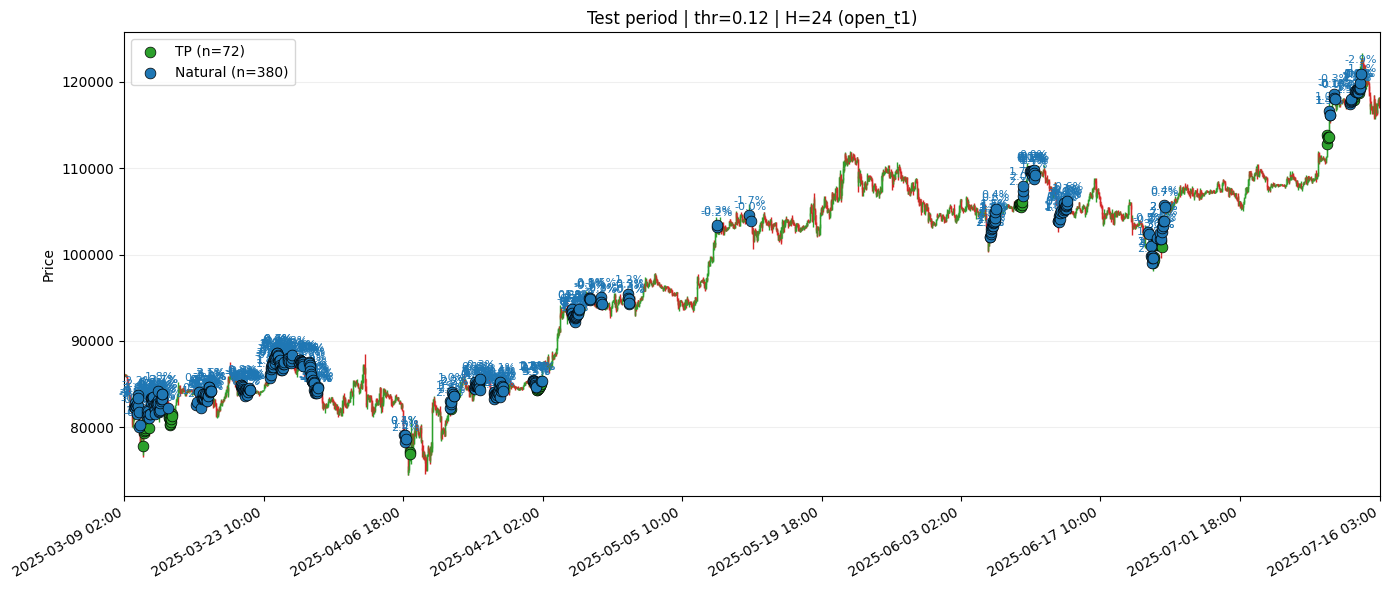

In [99]:
plot_entries_on_candles(pred_test, ohlcv, threshold=0.12, name="Test period", horizon_bars=24, entry_mode="open_t1", annotate_ret=True)


In [148]:
# Update: add avg natural-close returns (triggered vs all) to evaluator
import numpy as np
import pandas as pd
from typing import Optional

def evaluate_trades_ternary_with_ohlcv(
    df: pd.DataFrame,
    ohlcv: pd.DataFrame,
    threshold: float,
    *,
    tp_pct: float = 0.04,
    sl_pct: float = 0.02,
    p_col: str = "y_pred",
    ts_col: str = "timestamp",
    horizon_bars: int = 24,
    entry_mode: str = "close_t",
    tie_policy: str = "conservative",
    log_returns: bool = False,
    notional: float = 1.0,
    name: Optional[str] = None,
    return_trades: bool = False,
):
    # Normalize OHLCV
    def _norm_ts(s: pd.Series) -> pd.Series:
        ts = pd.to_datetime(s, errors="coerce", utc=True)
        return ts.dt.tz_convert("UTC").dt.tz_localize(None)

    o = ohlcv.copy()
    if isinstance(o.index, pd.DatetimeIndex):
        o.index = _norm_ts(pd.Series(o.index))
        o[ts_col] = o.index
    else:
        o[ts_col] = _norm_ts(o[ts_col])
        o = o.set_index(ts_col, drop=False)
    for c in ("open","high","low","close"):
        o[c] = pd.to_numeric(o[c], errors="coerce")

    # Filter entries by threshold
    data = df[[ts_col, p_col]].dropna(subset=[ts_col, p_col]).copy()
    entries = data.loc[data[p_col] > threshold].copy()
    n_trades = len(entries)
    if name:
        print(f"[simulate] {name} | threshold={threshold:.3f} | selected_trades={n_trades}")

    # Precompute arrays and index maps
    idx_map = pd.Series(np.arange(len(o), dtype=int), index=o.index)
    base_idx_all = _norm_ts(df[ts_col]).map(idx_map)
    base_idx_entries = _norm_ts(entries[ts_col]).map(idx_map)

    open_arr = o["open"].to_numpy()
    high_arr = o["high"].to_numpy()
    low_arr = o["low"].to_numpy()
    close_arr = o["close"].to_numpy()

    # Helper: natural-close return for a vector of base indices
    def nc_ret_vec(base_idx: pd.Series) -> pd.Series:
        start = base_idx + (1 if entry_mode == 'open_t1' else 0)
        end = base_idx + horizon_bars
        n = len(close_arr)
        valid = start.notna() & end.notna() & (start >= 0) & (end >= 0) & (start < n) & (end < n)
        out = pd.Series(np.nan, index=base_idx.index, dtype=float)
        if valid.any():
            s = start[valid].astype(int).to_numpy()
            e = end[valid].astype(int).to_numpy()
            entry = open_arr[s] if entry_mode == 'open_t1' else close_arr[s]
            exitp = close_arr[e]
            with np.errstate(divide='ignore', invalid='ignore'):
                ret = (np.log(exitp) - np.log(entry)) if log_returns else (exitp / entry - 1.0)
            out.loc[valid] = ret
        return out

    # Compute NC returns for all rows and for selected entries
    ret_nc_all = nc_ret_vec(base_idx_all)
    ret_nc_entries = nc_ret_vec(base_idx_entries)

    # If no trades, return baseline metrics including avg NC returns
    if n_trades == 0:
        avg_nc_all = float(ret_nc_all.dropna().mean()) if ret_nc_all.notna().any() else float('nan')
        res = {
            'threshold': threshold,
            'n_trades': 0,
            'n_tp': 0, 'n_sl': 0, 'n_natural': 0,
            'avg_return': float('nan'),
            'sum_return': 0.0,
            'pnl_notional': 0.0,
            'tp_pct': tp_pct, 'sl_pct': sl_pct,
            'horizon_bars': horizon_bars, 'entry_mode': entry_mode,
            'avg_nc_return_triggered': float('nan'),
            'n_nc_ret_triggered': 0,
            'avg_nc_return_all': avg_nc_all,
            'n_nc_ret_all': int(ret_nc_all.notna().sum()),
        }
        return (res, entries.assign(y_outcome=np.nan, ret=np.nan, ret_nc=ret_nc_entries.reindex(entries.index))) if return_trades else res

    # Compute outcomes and PnL for selected entries
    outcomes = []
    rets = []
    first_hit_bar = []

    for bi_val in base_idx_entries.values:
        if pd.isna(bi_val):
            outcomes.append(0)
            rets.append(np.nan)
            first_hit_bar.append(np.nan)
            continue
        bi = int(bi_val)
        # Entry
        ei = bi + 1 if entry_mode == 'open_t1' else bi
        if ei < 0 or ei >= len(open_arr):
            outcomes.append(0)
            rets.append(np.nan)
            first_hit_bar.append(np.nan)
            continue
        entry_price = open_arr[ei] if entry_mode == 'open_t1' else close_arr[ei]
        if not (np.isfinite(entry_price) and entry_price > 0):
            outcomes.append(0)
            rets.append(np.nan)
            first_hit_bar.append(np.nan)
            continue
        up = entry_price * (1.0 + tp_pct)
        dn = entry_price * (1.0 - sl_pct)
        first = None
        label = None
        # scan (t+1..t+H]
        start = bi + 1
        end = min(bi + horizon_bars, len(o) - 1)
        for j in range(start, end + 1):
            h = high_arr[j]
            l = low_arr[j]
            hit_up = (h >= up) if np.isfinite(h) else False
            hit_dn = (l <= dn) if np.isfinite(l) else False
            if not hit_up and not hit_dn:
                continue
            first = j
            if hit_up and not hit_dn:
                label = 1
            elif hit_dn and not hit_up:
                label = -1
            else:
                if tie_policy == 'proximity_to_open':
                    bar_open = open_arr[j]
                    if np.isfinite(bar_open):
                        du = abs(up - bar_open)
                        dd = abs(bar_open - dn)
                        label = 1 if du < dd else -1
                    else:
                        label = 0
                else:
                    label = 0
            break
        if label is None:
            label = 0
        outcomes.append(label)
        first_hit_bar.append(first if first is not None else np.nan)
        # payoff
        if label == 1:
            rets.append(tp_pct)
        elif label == -1:
            rets.append(-sl_pct)
        else:
            rets.append(ret_nc_entries.loc[base_idx_entries.index[0]] if False else np.nan)  # placeholder

    entries = entries.copy()
    entries['y_outcome'] = np.array(outcomes, dtype=float)
    # assign natural-close returns per entry
    entries['ret_nc'] = ret_nc_entries.reindex(entries.index)
    # build final per-trade return
    entries['ret'] = np.where(entries['y_outcome'] == 1, tp_pct,
                       np.where(entries['y_outcome'] == -1, -sl_pct, entries['ret_nc']))
    entries['first_hit_bar'] = np.array(first_hit_bar, dtype=float)

    n_tp = int((entries['y_outcome'] == 1).sum())
    n_sl = int((entries['y_outcome'] == -1).sum())
    n_nc = int((entries['y_outcome'] == 0).sum())

    sum_ret = float(np.nansum(entries['ret']))
    avg_ret = float(np.nanmean(entries['ret'])) if n_trades > 0 else float('nan')

    # Natural-close averages requested
    avg_nc_triggered = float(entries['ret_nc'].dropna().mean()) if entries['ret_nc'].notna().any() else float('nan')
    avg_nc_all = float(ret_nc_all.dropna().mean()) if ret_nc_all.notna().any() else float('nan')

    res = {
        'threshold': threshold,
        'n_trades': n_trades,
        'n_tp': n_tp,
        'n_sl': n_sl,
        'n_natural': n_nc,
        'avg_return': avg_ret,
        'sum_return': sum_ret,
        'pnl_notional': sum_ret * notional,
        'tp_pct': tp_pct,
        'sl_pct': sl_pct,
        'horizon_bars': horizon_bars,
        'entry_mode': entry_mode,
        'tie_policy': tie_policy,
        'avg_nc_return_triggered': avg_nc_triggered,
        'n_nc_ret_triggered': int(entries['ret_nc'].notna().sum()),
        'avg_nc_return_all': avg_nc_all,
        'n_nc_ret_all': int(ret_nc_all.notna().sum()),
        'name': name,
    }
    return (res, entries) if return_trades else res


In [159]:
evaluate_trades_ternary_with_ohlcv(
pred_test, ohlcv, threshold=0.12,
tp_pct=0.04, sl_pct=0.02,
ts_col="timestamp", p_col="y_pred",
horizon_bars=24, entry_mode="close_t", tie_policy="conservative",
log_returns=False, return_trades=True
)

({'threshold': 0.12,
  'n_trades': 452,
  'n_tp': 72,
  'n_sl': 113,
  'n_natural': 267,
  'avg_return': 0.005811410877311731,
  'sum_return': 2.626757716544902,
  'pnl_notional': 2.626757716544902,
  'tp_pct': 0.04,
  'sl_pct': 0.02,
  'horizon_bars': 24,
  'entry_mode': 'close_t',
  'tie_policy': 'conservative',
  'avg_nc_return_triggered': 0.0077707674872045185,
  'n_nc_ret_triggered': 452,
  'avg_nc_return_all': 0.0030356032569757332,
  'n_nc_ret_all': 3259,
  'name': None},
                timestamp    y_pred  y_outcome    ret_nc       ret  \
 0    2025-03-10 02:00:00  0.155920       -1.0 -0.034622 -0.020000   
 1    2025-03-10 03:00:00  0.161146       -1.0 -0.030652 -0.020000   
 2    2025-03-10 04:00:00  0.142777       -1.0 -0.034708 -0.020000   
 3    2025-03-10 05:00:00  0.138048       -1.0 -0.025008 -0.020000   
 4    2025-03-10 06:00:00  0.142777       -1.0 -0.027153 -0.020000   
 ...                  ...       ...        ...       ...       ...   
 3021 2025-07-13 23:00:00 